<a href="https://colab.research.google.com/github/HayrullahKaraman/Machine_Learning_Project/blob/main/MTA_EDA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
num_weeks = 8

#ilk hafta belirtiliyor
start_date = filedate = pd.Timestamp('2022-04-09 00:00:00')

#genel url belirtiliyor sınunda list ekleniyor
url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"

filelist = []

for numfiles in range (num_weeks):

    # create the appropriate filename for the week
    filedate_str = str(filedate.year)[2:4] + str(filedate.month).zfill(2) + str(filedate.day).zfill(2)#Yıl son 2 , ay 2, gün 2 format alır
    filename = url.format(filedate_str)

    #filename ile belirtilen  url filelist ekeleniyor
    df = pd.read_csv(filename, parse_dates=['TIME'], infer_datetime_format=True)
    filelist.append(df)

    # her bir txt 7 günlük oluştuğu için 7 gün eklenerek bir sonraki url gecer
    filedate += pd.Timedelta(days=7)
#file listde toplanan urller df ekleniyor 
df = pd.concat(filelist, axis=0, ignore_index=True)

In [3]:
pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline

In [4]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2022,2022-10-08 00:00:00,REGULAR,7698997,2686961
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2022,2022-10-08 04:00:00,REGULAR,7699002,2686968
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2022,2022-10-08 08:00:00,REGULAR,7699008,2686998
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2022,2022-10-08 12:00:00,REGULAR,7699024,2687085
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/02/2022,2022-10-08 16:00:00,REGULAR,7699062,2687148


In [5]:
df.rename(columns = {'EXITS                                                               ':'EXITS'},inplace = True)
df['TURNSTILE'] = df['C/A']+'-'+df['UNIT']+'-'+df['SCP']

df['HOURS'] = df['TIME'].dt.hour
df['MINUTE'] = df['TIME'].dt.minute
df['DATE'] = pd.to_datetime(df.DATE)
df['DAY'] = df["DATE"].dt.day_name()

In [6]:
df['ENTRIES'] = df['ENTRIES'].diff().fillna(df['ENTRIES'].iloc[0])
df['EXITS'] = df['EXITS'].diff().fillna(df['EXITS'].iloc[0])
df['TRAFFIC'] = df['ENTRIES']+df['EXITS']

In [7]:
df = df.drop(df[(df.TRAFFIC <= 0)].index)
df=df.reset_index().drop(index=[0,1])

In [8]:
df=df.reset_index()

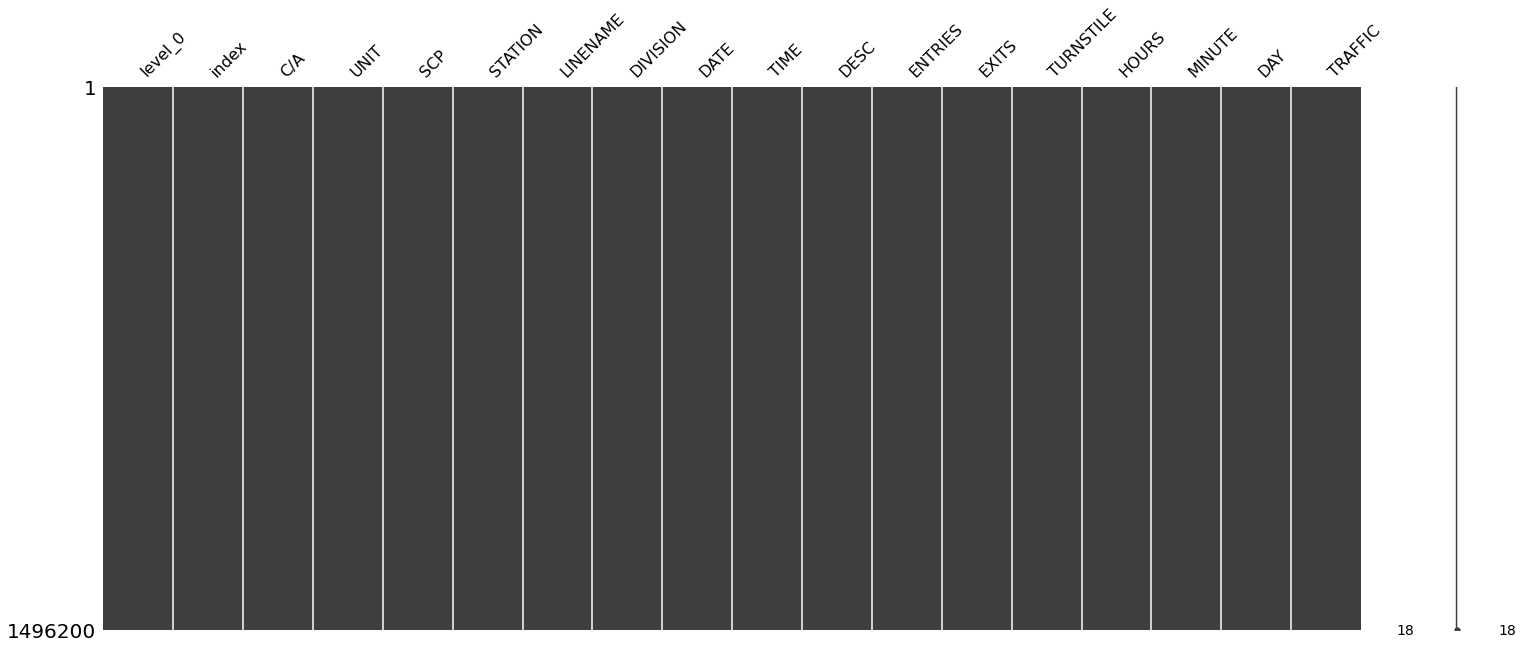

In [9]:
msno.matrix(df);
plt.savefig('Nullcheck.png')

In [10]:
df['TRAFFIC'] = df['TRAFFIC'].apply(int)

In [11]:
def extract_whiskers(data):
    median_value = np.median(data) # Medyan
    upper_quartile = np.percentile(data, 75) # 75%
    lower_quartile = np.percentile(data, 25) # 25% 
    iqr = upper_quartile - lower_quartile #Interquartile Range
    print("Upper Whisker:", data[data<=upper_quartile+1.5*iqr].max()) # Maksimum Kabul Edilen Değer
    print("Lower Whisker:", data[data>=lower_quartile-1.5*iqr].min())

In [12]:
upper = 617 + (251.0*1.5)
lower = abs(21 - (251.0*1.5))
print(lower)
print(upper)

355.5
993.5


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


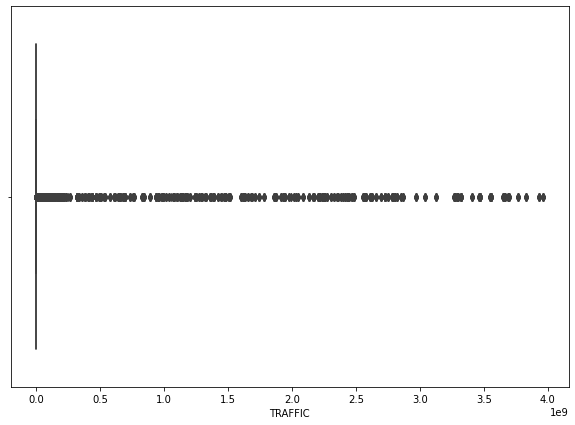

In [13]:
plt.figure(figsize = [10,7])
sns.boxplot(df['TRAFFIC']);
plt.savefig('rafficBoxplot.png')

In [14]:
df2= df.loc[(df['HOURS'] > 6) & (df['HOURS'] <23 ) & (df['TRAFFIC'] > 20) & (df['TRAFFIC'] < 993) ]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


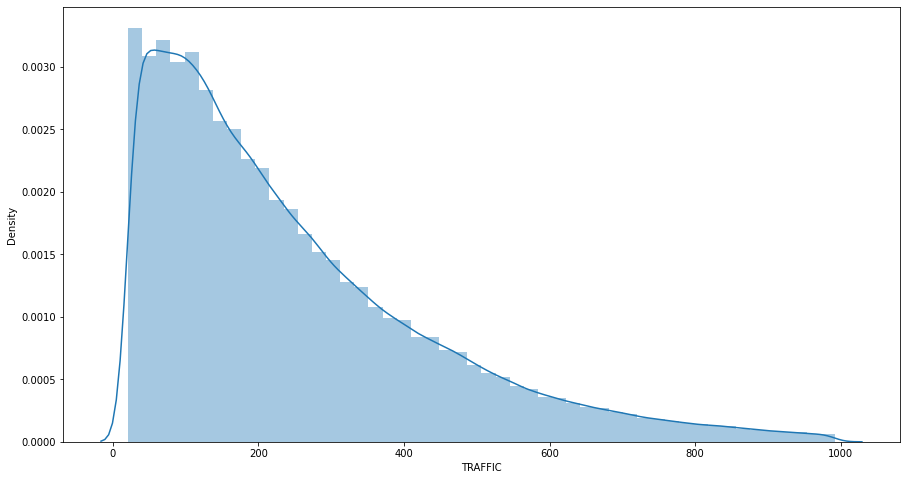

<Figure size 432x288 with 0 Axes>

In [15]:
plt.figure(figsize = [15,8])
sns.distplot(df2['TRAFFIC'])
plt.show();

plt.savefig('FilterTraffic.png')

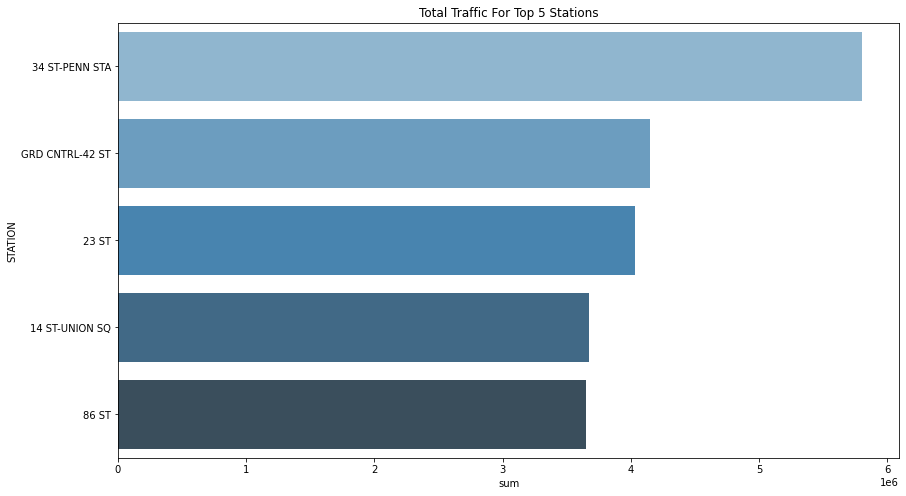

In [16]:
plt.figure(figsize=(14, 8))
plt.title("Total Traffic For Top 5 Stations")
station = df2.groupby(['STATION']).TRAFFIC.agg(['sum']).reset_index()
station =station.nlargest(5,'sum')
sns.barplot(x="sum", y="STATION", orient = "h", data=station, palette = "Blues_d")

plt.savefig('Top5station.png')

In [17]:
station_daily = df.groupby(["STATION","DATE"])[['TRAFFIC']].sum().reset_index()

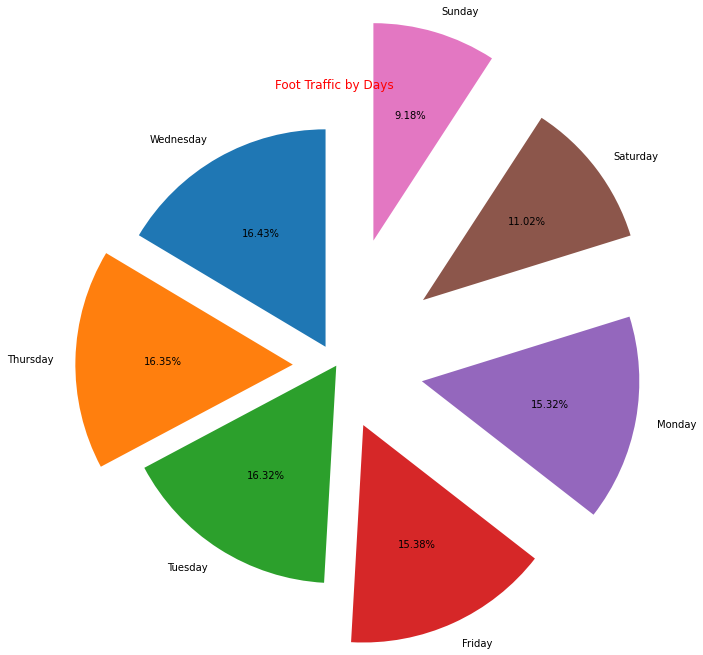

In [18]:
day=df2.groupby(['DAY']).TRAFFIC.agg('mean').nlargest(7)
plt.figure(figsize=[20,10])
plt.pie(day, labels=day.index, autopct='%1.2f%%', startangle=90,explode =[.1,.2,0,.3,.4,.5,.6])
plt.title("Foot Traffic by Days ", color="red");
plt.savefig('Businessday.png')

In [ ]:
#hours = df2.groupby(['HOURS']).DAY.agg('sum')

In [19]:
busiest_stations = df2.groupby("DAY").mean().sort_values("TRAFFIC", ascending = False).reset_index().head(10)
busiest_stations.head(10)

,DAY,level_0,index,ENTRIES,EXITS,HOURS,MINUTE,TRAFFIC
0,Wednesday,746727.73,844038.24,130.13,151.10,14.45,2.30,281.23
1,Thursday,747755.08,845199.89,129.24,150.65,14.46,2.25,279.90
2,Tuesday,748475.11,846014.99,129.43,149.99,14.45,2.21,279.42
3,Friday,747436.30,844838.54,120.20,142.99,14.49,2.22,263.19
4,Monday,748150.65,845648.35,120.67,141.60,14.47,2.18,262.27
5,Saturday,745129.60,842229.23,78.95,109.63,14.78,1.99,188.59
6,Sunday,746511.99,843790.47,64.77,92.38,14.94,2.00,157.15


In [20]:
# Top 10 Stations list
top10_list = list(station['STATION'])
# Top 10 Stations df
top10_df = df2[df2['STATION'].isin(top10_list)]

In [21]:
top5_daily = top10_df.groupby(["STATION","DATE","DAY"])[['TRAFFIC']].sum().reset_index()

top5_dow = top5_daily.groupby(['STATION','DAY'])['TRAFFIC']\
                .mean().round(0)\
                .reset_index().sort_values('TRAFFIC',ascending=False)

In [22]:
top5_dow_hm = top5_dow.pivot(index=["STATION"], columns=['DAY'], values='TRAFFIC')

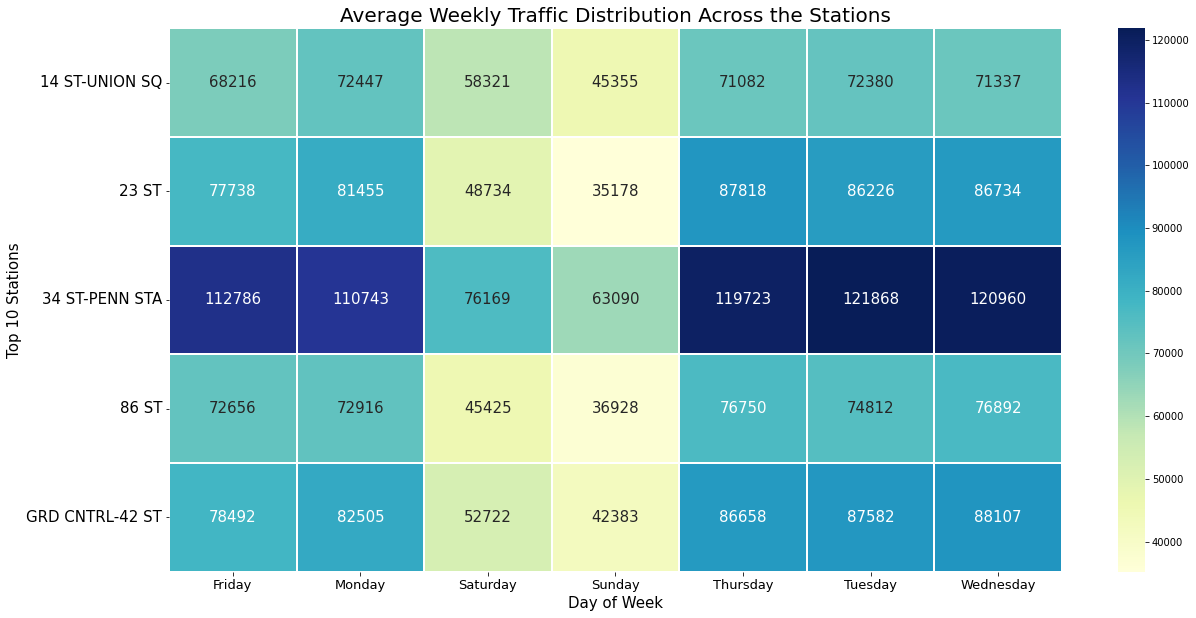

In [23]:
plt.figure(figsize=[20,10])
plt.title("Top 5 Stations Traffic pattern", size=30, weight='bold')
sns.heatmap(top5_dow_hm, cmap='YlGnBu', linecolor='white', linewidths=1, annot=True, fmt=".0f", annot_kws={"size":15})
plt.title("Average Weekly Traffic Distribution Across the Stations", size=20)
plt.xlabel("Day of Week", size=15)
plt.ylabel("Top 10 Stations", size=15)
plt.xticks(size=13)
plt.yticks(size=15, rotation=0)

plt.savefig('WeeklyTraffic.png')

In [24]:
top10_daily = top10_df.groupby(["STATION","HOURS","DAY"])[['TRAFFIC']].sum().reset_index()

In [25]:
top10_daily_summary = top10_daily.groupby(['DAY','HOURS'])['TRAFFIC']\
                .mean().round(0)\
                .reset_index().sort_values('TRAFFIC',ascending=False)

In [26]:
top10_daily_pivot = top10_daily_summary.pivot(index=['DAY'], columns=['HOURS'], values='TRAFFIC')

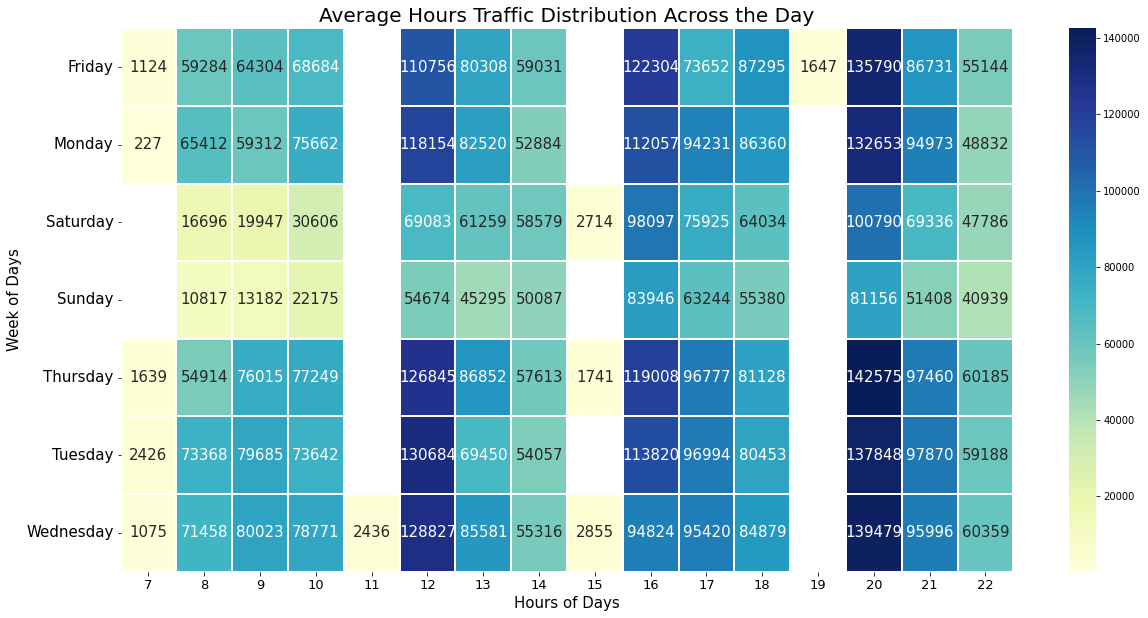

In [27]:
plt.figure(figsize=[20,10])
plt.title("Weekly Traffic Pattern", size=30, weight='bold')
sns.heatmap(top10_daily_pivot, cmap='YlGnBu', linecolor='white', linewidths=1, annot=True, fmt=".0f", annot_kws={"size":15})
plt.title("Average Hours Traffic Distribution Across the Day", size=20)
plt.xlabel("Hours of Days", size=15)
plt.ylabel("Week of Days", size=15)
plt.xticks(size=13)
plt.yticks(size=15, rotation=0);
plt.savefig('Hourstraffic.png')

In [29]:
turnstile_mask = df2[(df2.TRAFFIC > 700 )&(df2.STATION == '34 ST-PENN STA')].groupby(['TURNSTILE','STATION']).TRAFFIC.max().reset_index()#(df2.STATION == '34 ST-PENN STA') & 

turnstile_top = turnstile_mask.groupby(["STATION","TURNSTILE"])[['TRAFFIC']].sum().reset_index() 
turnstile_top_summary = turnstile_top.groupby(['TURNSTILE','STATION'])['TRAFFIC']\
                .mean().round(0)\
                .reset_index().sort_values('TRAFFIC',ascending=False)

In [30]:
turnstile_mask['TURNSTILE'] =turnstile_mask.TURNSTILE.apply(str) #df['TRAFFIC'] = df['TRAFFIC'].apply(int)


In [31]:
turnstile_pivot = turnstile_top_summary.pivot(index = ['STATION'], columns= ['TURNSTILE'],values = ['TRAFFIC']  )

In [ ]:
turnstile_pivot

TRAFFIC                                        \
TURNSTILE      N067-R012-00-00-00 N067-R012-00-03-00 N067-R012-00-05-00   
STATION                                                                   
34 ST-PENN STA             791.00             943.00             992.00   

                                                                         \
TURNSTILE      N067-R012-00-05-01 N069-R013-01-00-02 N070-R012-04-00-01   
STATION                                                                   
34 ST-PENN STA             961.00             779.00             708.00   

                                                                         \
TURNSTILE      N070-R012-04-00-04 N071-R013-00-00-00 N073-R013-02-00-01   
STATION                                                                   
34 ST-PENN STA             708.00             913.00             928.00   

                                   ...                                        \
TURNSTILE      N073-R013-02-00-02  ... R138-R293-00-00-02 R138-R293-00-00-03   
STATION                            ...                                         
34 ST-PENN STA             969.00  ...             991.00             890.00   

                                                                         \
TURNSTILE      R138-R293-00-00-04 R138-R293-00-02-00 R138-R293-00-03-01   
STATION                                                                   
34 ST-PENN STA             729.00             787.00             812.00   

                                                                         \
TURNSTILE      R138-R293-00-03-02 R138-R293-00-03-03 R138-R293-00-03-04   
STATION                                                                   
34 ST-PENN STA             988.00             991.00             991.00   

                                                      
TURNSTILE      R141-R031-00-00-00 R142-R293-01-00-03  
STATION                                               
34 ST-PENN STA             823.00             963.00  

[1 rows x 28 columns]

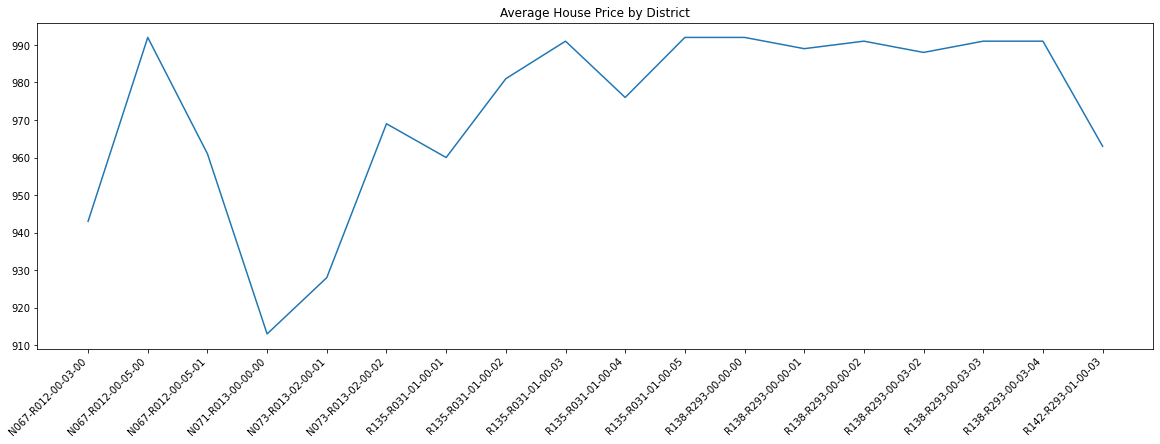

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(turnstile_mask['TURNSTILE'], turnstile_mask['TRAFFIC']);
plt.xticks(rotation=45, ha='right')
plt.title("Average House Price by District");

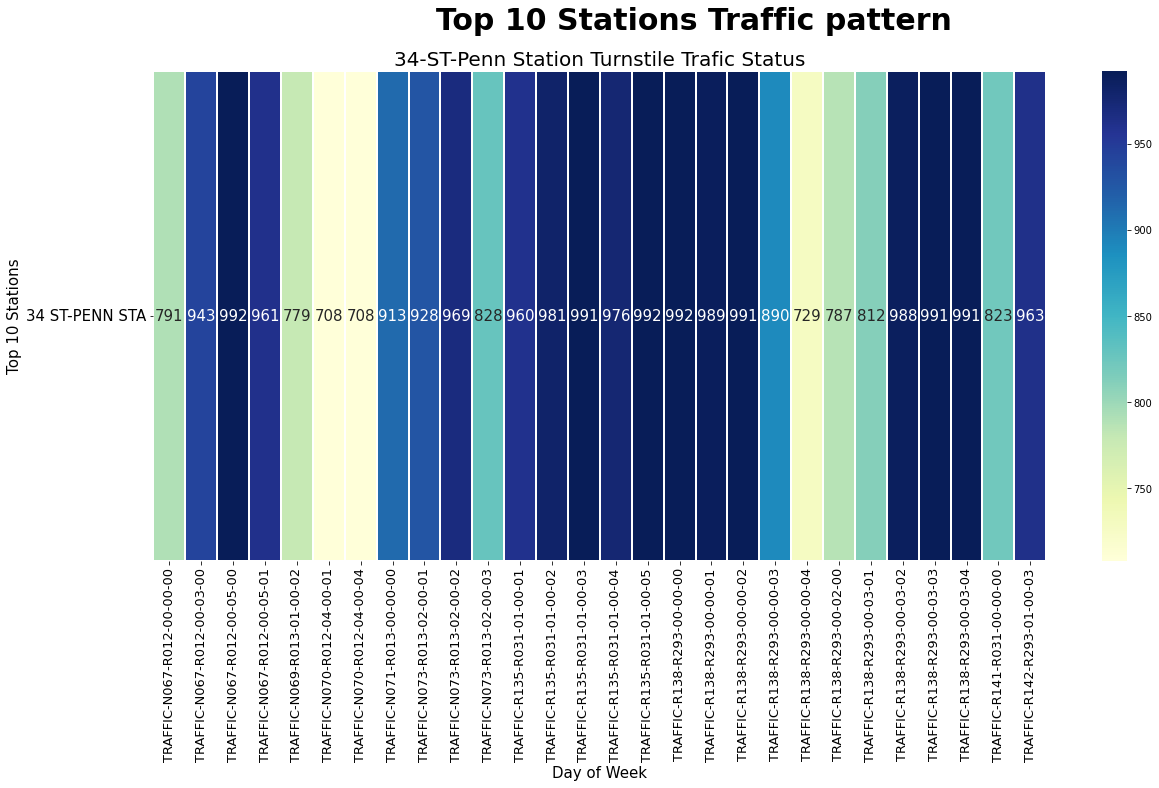

In [32]:
plt.figure(figsize=[20,9])
plt.suptitle("Top 10 Stations Traffic pattern", size=30, weight='bold')
sns.heatmap(turnstile_pivot, cmap='YlGnBu', linecolor='white', linewidths=1, annot=True, fmt=".0f", annot_kws={"size":15})
plt.title("34-ST-Penn Station Turnstile Trafic Status", size=20)
plt.xlabel("Day of Week", size=15)
plt.ylabel("Top 10 Stations", size=15)
plt.xticks(size=13)
plt.yticks(size=15, rotation=0)

plt.savefig('34ST-turnstile.png')